In [25]:
import numpy as np
from mnist import MNIST
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

In [2]:
mnist_loader = MNIST("../data/mnist/")
mnist_loader.gz = True

In [3]:
images, labels = mnist_loader.load_training()
# uncomment if test data needed
timages, tlabels = mnist_loader.load_testing()

In [4]:
images = np.array(images)
labels = np.array(labels)
timages = np.array(timages)
tlabels = np.array(tlabels)

In [5]:
images = np.concatenate((images, timages))
labels = np.concatenate((labels, tlabels))

In [6]:
images.shape#, timages.shape

(70000, 784)

In [7]:
n_rows = images.shape[0]
dims = images.shape[1]
#t_n_rows = timages.shape[0]

In [8]:
n_rows, dims

(70000, 784)

In [9]:
del timages, tlabels

# kmeans
## init

Randomly pick 10 images as starting points.

In [10]:
def init(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    for rand in range(k):
        img_id = np.random.choice(n_rows)
        mu[rand] = images[img_id]
    return mu

`init_dist` takes into account the distances of different points when picking stating mu's.

In [11]:
def init_dist(k, seed):
    if seed != None:
        np.random.seed(seed)
    mu = np.empty((k, images.shape[1]))
    memmap = '../data/mnist/dist.memmap'
    fp = np.memmap(memmap, dtype='float32', shape=(n_rows, n_rows - 10000), mode='r')
    
    ids = []
    img_id = np.random.choice(n_rows)
    ids.append(img_id)
    mu[0] = images[img_id]
    for rand in range(1, k):
        distances = fp[img_id].copy()
        img_id = np.argmax(distances)
        while img_id in ids:
            distances[img_id] = -1
            img_id = np.argmax(distances)
        mu[rand] = images[img_id]
        ids.append(img_id)        
    del fp
    
    return mu

## E step
Assign memberships from current mu's. <br>
Also evaluate loss

In [23]:
def e_step(mu):
    distances = np.matrix(euclidean_distances(X=images, Y=mu))
    loss = np.sum(distances.min(axis=1))
    return np.array(distances.argmin(1).T).ravel(), loss

## M step
Calculate new mu's from current memberships

In [13]:
def m_step(pi, k):
    mu = np.empty((k, images.shape[1]))
    for cluster_id in range(k):
        cluster_images = images[np.where(pi == cluster_id)[0]]
        mu[cluster_id] = np.mean(cluster_images, axis=0)
    return mu

## external metrics

Helper function to get confusion matrix and cluster mappings for `k` and `pi`'s

In [14]:
def get_confusion_matrix(k, pi):
    conf_mat = [[0 for x in range(k)] for y in range(k)]
    for cluster_id in range(k):
        true_labels = labels[np.where(cluster_id == pi)]
        conf_mat[cluster_id] = np.bincount(true_labels)
    return np.array(conf_mat)

### Purity

In [15]:
def purity(confusion_matrix):
    Pj = confusion_matrix.max(axis=1)
    Mj = confusion_matrix.sum(axis=1)
    return sum(Pj)/sum(Mj)

### Gini

In [16]:
def gini(confusion_matrix):
    Mj = confusion_matrix.sum(axis=1, keepdims=True)
    gj = 1 - ((confusion_matrix/Mj)**2).sum(axis=1, keepdims=True)
    return (sum(gj*Mj)/sum(Mj))[0]

## k means helper

In [17]:
def kmeans(k, init_func, max_epochs, print_interval, seed):
    _loss, _purity, _gini = [], [], []
    _mu = init_func(k, seed)
    for _epoch in range(max_epochs):
        # e step
        _pi, loss = e_step(_mu)
        # m step
        mu = m_step(_pi, k)
        
        # evaluation
        conf_mat = get_confusion_matrix(k, _pi)
        p = purity(conf_mat)
        g = gini(conf_mat)
        
        # append to global
        _purity.append(p)
        _gini.append(g)
        _loss.append(loss)
        
        # print info
        if _epoch % print_interval == 0:
            print('\tEpoch:', _epoch, 'Loss:', loss, 
                  'Purity:', p, 'Gini Index:', g)
                
        # check for convergence
        if np.allclose(_mu, mu):
            print('\tConvergence at epoch {0}, Loss at {1}'.format(_epoch, loss))
            break
        _mu = mu
        if _epoch == (max_epochs - 1):
            print('\tNo convergence after {0} epochs, try higher value. Loss at {1}'.format(max_epochs, loss))
            
    return _loss, _purity, _gini

## graph helpers

In [29]:
def graph_helper_loss(loss):
    plt.plot(range(len(loss)), np.log(loss))
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log_10)')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [30]:
def graph_helper_metrics(purity, gini):
    plt.plot(range(len(gini)), gini, 'r', label = 'Gini Index')
    plt.plot(range(len(purity)), purity, 'g', label = 'Purity')
    plt.xlabel('Epochs')
    plt.ylabel('Gini Index/Purity')
    plt.title('Gini Index/Purity vs Epochs')
    plt.legend()
    plt.show()

## All together

In [33]:
def do_kmeans(ks):
    seed = np.random.randint(n_rows)
    
    for k in ks:
        print('For k = {0}:'.format(k))
        t_loss, t_purity, t_gini = kmeans(k=k, init_func=init, 
                                          max_epochs=100, 
                                          print_interval=10, 
                                          seed=seed)
        
        print('\n\tFinal values: \n\t\tLoss: {0}'.format(t_loss[-1]))
        print('\t\tPurity: {0}'.format(t_purity[-1]))
        print('\t\tGini Index: {0}\n'.format(t_gini[-1]))
        
        graph_helper_loss(t_loss)
        graph_helper_metrics(t_purity, t_gini)

For k = 10:
	Epoch: 0 Loss: 151897665.132 Purity: 0.383142857143 Gini Index: 0.747103141263
	Epoch: 10 Loss: 110852203.658 Purity: 0.5519 Gini Index: 0.571775698753
	Epoch: 20 Loss: 110817590.793 Purity: 0.549657142857 Gini Index: 0.571682808517
	Epoch: 30 Loss: 110796583.79 Purity: 0.544542857143 Gini Index: 0.574873887132
	Epoch: 40 Loss: 110679447.645 Purity: 0.525414285714 Gini Index: 0.585139104342
	Epoch: 50 Loss: 110256067.94 Purity: 0.556028571429 Gini Index: 0.570911858449
	Epoch: 60 Loss: 110220357.195 Purity: 0.564785714286 Gini Index: 0.566542922327
	Epoch: 70 Loss: 110214301.968 Purity: 0.565814285714 Gini Index: 0.566292872936
	Epoch: 80 Loss: 110212714.495 Purity: 0.566271428571 Gini Index: 0.566161905097
	Epoch: 90 Loss: 110212511.333 Purity: 0.566742857143 Gini Index: 0.566298253344
	No convergence after 100 epochs, try higher value. Loss at 110210053.49787845

	Final values: 
		Loss: 110210053.49787845
		Purity: 0.5669285714285714
		Gini Index: 0.5663364378599246



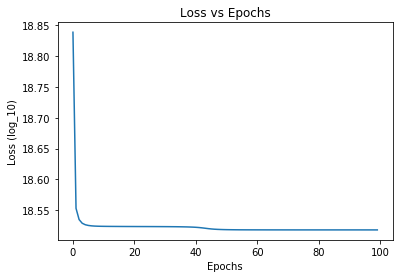

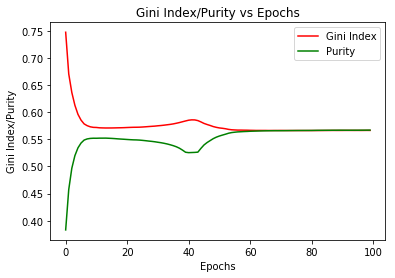

For k = 5:
	Epoch: 0 Loss: 158202928.7 Purity: 0.268342857143 Gini Index: 0.822421120111
	Epoch: 10 Loss: 116302736.383 Purity: 0.450542857143 Gini Index: 0.672150609703
	Epoch: 20 Loss: 116182262.634 Purity: 0.452342857143 Gini Index: 0.658845274719
	Convergence at epoch 29, Loss at 116179614.39332554

	Final values: 
		Loss: 116179614.39332554
		Purity: 0.45248571428571427
		Gini Index: 0.6583535127516839



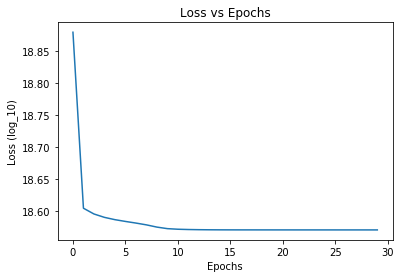

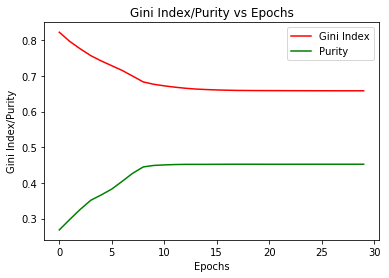

For k = 20:
	Epoch: 0 Loss: 138579221.888 Purity: 0.489314285714 Gini Index: 0.659936771791
	Epoch: 10 Loss: 104279419.841 Purity: 0.693571428571 Gini Index: 0.421962200306
	Epoch: 20 Loss: 104056820.305 Purity: 0.702085714286 Gini Index: 0.411013327243
	Epoch: 30 Loss: 104034533.599 Purity: 0.705128571429 Gini Index: 0.406578461963
	Epoch: 40 Loss: 104026204.645 Purity: 0.705714285714 Gini Index: 0.405182920804
	Epoch: 50 Loss: 104023866.358 Purity: 0.706242857143 Gini Index: 0.404634541243
	Epoch: 60 Loss: 104024399.517 Purity: 0.706142857143 Gini Index: 0.404829685799
	Epoch: 70 Loss: 104024312.036 Purity: 0.705957142857 Gini Index: 0.404875790322
	Epoch: 80 Loss: 104024587.206 Purity: 0.706057142857 Gini Index: 0.404831424484
	Convergence at epoch 81, Loss at 104024595.35927899

	Final values: 
		Loss: 104024595.35927899
		Purity: 0.7060571428571428
		Gini Index: 0.4048314244835568



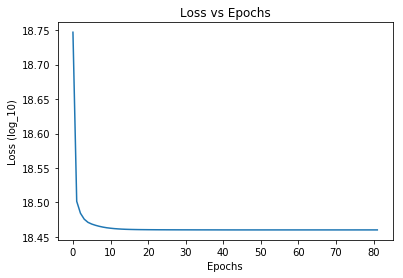

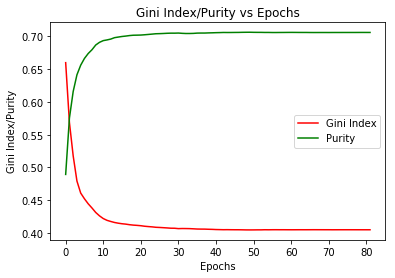

In [34]:
do_kmeans([10, 5, 20])